# 供应链建模与分析 项目：库存规划系统

**项目：库存规划系统**

Amazing Coffee 决定在香港开设一家店铺，并销售三款最受欢迎的饮品——卡布奇诺、拿铁和摩卡，其配方如下：  
1. **卡布奇诺**：咖啡豆（40g）、奶泡（10g）、蒸牛奶（10g）  
2. **拿铁**：咖啡豆（25g）、奶泡（5g）、蒸牛奶（20g）  
3. **摩卡**：咖啡豆（30g）、蒸牛奶（20g）、巧克力粉（15g）  

**库存规划背景**  
每周日，Amazing Coffee 需要预测接下来一周的需求。为降低缺货风险，采购部门需确保店内有足够的咖啡豆、奶泡、蒸牛奶和巧克力粉，以满足下一周的销售需求。过去 15 天的需求数据已记录在 Excel 文件 **“demand_history.xlsx”** 中。

**表 1：各原材料成本**  
| 原材料 | 咖啡豆 | 奶泡 | 蒸牛奶 | 巧克力粉 |
|--------|--------|--------|--------|--------|
| 每千克成本（周四除外） | $14 | $8 | $6 | $5 |
| 每千克成本（周四折扣价） | $11.9 | $6.8 | $5.1 | $4.25 |
| 库存持有成本（每天每千克） | $2.6 | $0.6 | $1 | $0.3 |

根据表 1，不同原料的成本各不相同，其中：
- 咖啡豆每千克 $14，奶泡 $8，蒸牛奶 $6，巧克力粉 $5。
- 由于供应商的促销活动，每周四可享受 15% 折扣价格。
- 周二和周五无法订购任何原材料。
- 公司可以提前订购原料并存储，但需支付库存持有成本。
- 周一之前不存有任何库存。

**项目目标**  
Amazing Coffee 计划开发一个系统，根据预测的需求制定订购计划，以优化成本（包括原材料成本和库存持有成本）。

### **任务要求**
1. **[方案] 需求预测**  
   - 作为公司代表，你需要使用数据驱动的预测方法预测下周（第 16 至 22 天）的需求。  
   - 报告你的预测模型（选择的预测方法、结果、假设和限制）。

2. **[方案] 订购计划优化**  
   - 制定原材料订购计划，确定订购时间和数量，以最小化整体成本。  
   - 针对此问题制定线性规划模型。

3. **[方案 + 原型] 用户界面设计**  
   - 创建一个界面，允许经理调整每日需求并规划新的订购计划。  
   - 可选地集成预测功能。

4. **[原型] 系统功能拓展**  
   - 添加更多功能，以评估不同成本参数下的决策影响。

5. **[方案] 结果分析**  
   - 讨论结果，并进行敏感性分析，评估订购计划的变化。

6. **[可选：方案 + 原型] 进一步优化**  
   - 提供扩展建议，演示如何改进规划系统，如考虑需求变化、订购策略、新产品设计等。

In [1]:
!pip install openpyxl
!pip install pandas
!pip install numpy
!pip install scikit-learn

# 任务 1

In [2]:
import pandas as pd
import numpy as np

In [3]:
import pandas as pd

# 加载需求历史数据
# 确保'demand_history.xlsx'文件与你的notebook在同一目录下，
# 或者提供完整路径。
try:
    df = pd.read_excel('demand_history.xlsx')

    # 显示前几行数据以了解结构
    print("数据的前5行:")
    print(df.head())
    print("\n--------------------\n")

    # 获取数据的基本信息（列、数据类型、非空值计数）
    print("数据框信息:")
    df.info()
    print("\n--------------------\n")

    # 检查每列缺失值
    print("每列缺失值:")
    print(df.isnull().sum())
    print("\n--------------------\n")

    # 获取基本描述性统计
    print("描述性统计:")
    print(df.describe(include='all')) # 使用include='all'查看非数值列的统计信息

except FileNotFoundError:
    print("错误: 未找到'demand_history.xlsx'。请确保文件在正确的目录中。")
except Exception as e:
    print(f"发生错误: {e}")


数据的前5行:
     Day Unnamed: 1  Cappuccino Sales  Latte Sales  Mocha Sales  Promotion Day
0  Day 1     Sunday              52.0         48.0         68.0              0
1  Day 2     Monday              40.0         70.0         40.0              0
2  Day 3    Tuesday              45.0         41.0         41.0              0
3  Day 4  Wednesday              56.0         58.0         57.0              0
4  Day 5   Thursday             106.0         88.0        112.0              1

--------------------

数据框信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Day               22 non-null     object 
 1   Unnamed: 1        22 non-null     object 
 2   Cappuccino Sales  15 non-null     float64
 3   Latte Sales       15 non-null     float64
 4   Mocha Sales       15 non-null     float64
 5   Promotion Day     22 non-null     int64  
dtypes: fl

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor # 添加随机森林作为另一个选项
from sklearn.metrics import mean_squared_error
import numpy as np

# 假设'df'是之前加载的数据框

# 1. 清理列名和数据类型
df = df.rename(columns={'Unnamed: 1': 'DayOfWeek'})

# 2. 分离已知数据（第1-15天）和需要预测的一周（第16-22天）
train_df = df.iloc[:15].copy()
predict_df_features = df.iloc[15:].copy() # 我们要预测的一周的特征

# 确保销售列是数值型，处理潜在错误
sales_cols = ['Cappuccino Sales', 'Latte Sales', 'Mocha Sales']
for col in sales_cols:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')

# 检查转换后是否有销售数据变为NaN（如果输入正确应该不会）
print("数值转换后训练数据中的缺失销售值:")
print(train_df[sales_cols].isnull().sum())
# 处理潜在的NaN值（例如，用中位数或平均值填充）
# train_df = train_df.fillna(train_df.median(numeric_only=True)) # 示例：用中位数填充

# 3. 特征工程：对星期几进行独热编码
# 我们需要对训练集和预测集一致地进行编码
combined_df = pd.concat([train_df[['DayOfWeek', 'Promotion Day']], predict_df_features[['DayOfWeek', 'Promotion Day']]], ignore_index=True)
combined_encoded = pd.get_dummies(combined_df, columns=['DayOfWeek'], drop_first=True) # drop_first避免多重共线性

# 将编码后的数据分回训练特征和预测特征
X_train_encoded = combined_encoded.iloc[:len(train_df)]
X_pred_encoded = combined_encoded.iloc[len(train_df):]

# 4. 定义目标变量（每种咖啡类型的销售量）
y_train_cap = train_df['Cappuccino Sales']
y_train_lat = train_df['Latte Sales']
y_train_moc = train_df['Mocha Sales']

# 显示形状以验证
print("\n训练特征和目标变量的形状:")
print("X_train_encoded:", X_train_encoded.shape)
print("y_train_cap:", y_train_cap.shape)
print("y_train_lat:", y_train_lat.shape)
print("y_train_moc:", y_train_moc.shape)

print("\n预测周的特征形状:")
print("X_pred_encoded:", X_pred_encoded.shape)

print("\n训练特征(X_train_encoded)头部:")
print(X_train_encoded.head())

print("\n预测特征(X_pred_encoded)头部:")
print(X_pred_encoded.head())


数值转换后训练数据中的缺失销售值:
Cappuccino Sales    0
Latte Sales         0
Mocha Sales         0
dtype: int64

训练特征和目标变量的形状:
X_train_encoded: (15, 7)
y_train_cap: (15,)
y_train_lat: (15,)
y_train_moc: (15,)

预测周的特征形状:
X_pred_encoded: (7, 7)

训练特征(X_train_encoded)头部:
   Promotion Day  DayOfWeek_Monday  DayOfWeek_Saturday  DayOfWeek_Sunday  \
0              0             False               False              True   
1              0              True               False             False   
2              0             False               False             False   
3              0             False               False             False   
4              1             False               False             False   

   DayOfWeek_Thursday  DayOfWeek_Tuesday  DayOfWeek_Wednesday  
0               False              False                False  
1               False              False                False  
2               False               True                False  
3               False            

In [5]:
# --- 模型训练与预测 ---

models = {}
predictions = {}

# 预测特征（第16-22天）
X_predict = X_pred_encoded

# 训练目标变量（第1-15天）
targets = {
    'Cappuccino': y_train_cap,
    'Latte': y_train_lat,
    'Mocha': y_train_moc
}

# 训练特征（第1-15天）
X_train = X_train_encoded

# --- 线性回归 ---
print("--- 使用线性回归进行训练和预测 ---")
lr_predictions = {}
for name, y_train in targets.items():
    print(f"训练{name}销量的线性回归模型...")
    model = LinearRegression()
    model.fit(X_train, y_train)
    models[f'LR_{name}'] = model
    preds = model.predict(X_predict)
    # 确保预测值非负（销售量不能为负）
    lr_predictions[f'{name}_LR_Pred'] = np.maximum(0, preds.round(0).astype(int))
    print(f"{name}销量预测(LR): {lr_predictions[f'{name}_LR_Pred']}")

# --- 随机森林回归 ---
print("\n--- 使用随机森林进行训练和预测 ---")
rf_predictions = {}
for name, y_train in targets.items():
    print(f"训练{name}销量的随机森林模型...")
    # 由于数据集较小，使用简单参数
    model = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=5, min_samples_leaf=2)
    model.fit(X_train, y_train)
    models[f'RF_{name}'] = model
    preds = model.predict(X_predict)
    # 确保预测值非负
    rf_predictions[f'{name}_RF_Pred'] = np.maximum(0, preds.round(0).astype(int))
    print(f"{name}销量预测(RF): {rf_predictions[f'{name}_RF_Pred']}")


# --- 将预测结果合并到数据框中 ---
predict_results_df = predict_df_features[['Day', 'DayOfWeek', 'Promotion Day']].reset_index(drop=True)

# 添加线性回归预测
for col_name, preds in lr_predictions.items():
    predict_results_df[col_name] = preds

# 添加随机森林预测
for col_name, preds in rf_predictions.items():
    predict_results_df[col_name] = preds


print("\n--- 第16-22天的预测销量 ---")
print(predict_results_df)

# --- 报告部分 ---
print("\n\n--- 预测报告 ---")
print("目标: 预测第16-22天的卡布奇诺、拿铁和摩卡的销量。")
print("使用数据: 第1-15天的销售数据。")
print("使用特征: 星期几（编码）、促销日（二元）。")

print("\n使用的模型:")
print("1. 线性回归(LR): 假设特征与销量之间存在线性关系。")
print("2. 随机森林回归器(RF): 基于树的集成方法，能够捕捉非线性关系。")

print("\n预测结果:")
print("上表('第16-22天的预测销量')展示了两种模型的预测销售数字。")
print("预测值已四舍五入到最接近的整数并限制为非负（销售量不能为负）。")

print("\n假设:")
print("*   第1-15天观察到的星期几/促销日与销售量之间的关系在第16-22天仍然成立。")
print("*   第16-22天期间没有其他重大外部因素显著影响销售（例如，星期几模式未能捕捉的节假日、天气）。")
print("*   '促销日'特征准确捕捉了促销的主要影响。")

print("\n局限性:")
print("*   非常小的数据集: 仅基于15个数据点进行训练很可能导致模型不稳健且不具普遍性。结果应谨慎对待。")
print("*   特征有限: 我们只使用了星期几和促销日。其他因素（天气、竞争对手行动、特定事件）未包含在内。")
print("*   无趋势/季节性组件: 这些模型没有明确考虑潜在的总体趋势或'星期几'捕获的每周模式之外的季节性。")
print("*   模型简单: 由于数据规模小，无法使用复杂模型或进行广泛的超参数调优。")

print("\n建议:")
print("鉴于局限性，尤其是小型数据集，这些预测提供了基本估计但具有高度不确定性。随机森林模型可能更好地捕捉潜在的非线性交互，但两种模型都受到有限数据的约束。将这些视为初步估计，并收集更多数据以进行未来更可靠的预测。")


--- 使用线性回归进行训练和预测 ---
训练Cappuccino销量的线性回归模型...
Cappuccino销量预测(LR): [ 51  48  56 113 136 112  69]
训练Latte销量的线性回归模型...
Latte销量预测(LR): [ 80  43  57  94 121 140  64]
训练Mocha销量的线性回归模型...
Mocha销量预测(LR): [ 55  45  59 131 165 132  83]

--- 使用随机森林进行训练和预测 ---
训练Cappuccino销量的随机森林模型...
Cappuccino销量预测(RF): [ 78  72  78 104  96 107  77]
训练Latte销量的随机森林模型...
Latte销量预测(RF): [ 90  69  78  94  96 122  73]
训练Mocha销量的随机森林模型...
Mocha销量预测(RF): [ 89  79  88 120 112 126  92]

--- 第16-22天的预测销量 ---
      Day  DayOfWeek  Promotion Day  Cappuccino_LR_Pred  Latte_LR_Pred  \
0  Day 16     Monday              0                  51             80   
1  Day 17    Tuesday              0                  48             43   
2  Day 18  Wednesday              0                  56             57   
3  Day 19   Thursday              1                 113             94   
4  Day 20     Friday              0                 136            121   
5  Day 21   Saturday              0                 112            140   
6  Da

让我们分析使用线性回归和随机森林的逻辑，以及它们在这种特定情况下的重大局限性。

**逻辑和合理性:**

1. 问题框架: 我们将任务框架为一个回归问题。我们希望根据可用的日期特征（星期几、促销日）预测数值（每种咖啡类型的销量）。
2. 特征选择: 数据集提供了星期几和促销日作为销量的潜在预测因子（特征）。我们假设这些因素可能影响每日销售数据。
3. 处理分类数据: 星期几是分类变量（星期日、星期一等）。模型需要数值输入，所以我们使用独热编码将每个星期转换为独立的二进制（0/1）列。这允许模型学习不同天数的不同影响。
4. 模型选择 - 为什么选择线性回归?
 - 简单性与基准: 这是一个基础回归模型。它假设特征（编码后的星期几、促销状态）与销量之间存在线性关系。它尝试找到数据的最佳直线拟合。
 - 可解释性: 相对容易理解模型如何权衡每个特征（尽管对编码特征来说不那么直观）。
 - 适合小数据（谨慎使用）: 对于非常小的数据集，简单模型有时被优先选择，因为与非常复杂的模型相比，它们不太可能严重过拟合。
5. 模型选择 - 为什么选择随机森林回归?
 - 捕捉非线性: 与线性回归不同，随机森林（决策树集成）可以自动捕捉非线性关系。例如，促销在周末与工作日相比可能有不成比例的大影响。RF可以潜在地模拟这一点而无需我们明确定义交互项。
 - 特征交互: 它可以隐式处理特征之间的交互（例如，'促销日'的效果可能取决于'星期几'）。
 - 稳健性（相对而言）: 通过平均在不同数据子集上训练的多棵树的预测，它通常比单个决策树更稳健，更不容易过拟合。
6. 训练/预测分割: 我们使用已知数据（第1-15天）训练模型，然后将训练好的模型应用于目标周（第16-22天）的特征，生成预测。


**模型的局限性（尤其是在本案例中）:**

前面报告中确定的局限性至关重要:

1. 极小的训练数据集（15天）: 这是最显著的局限性。
 - 高过拟合风险: 模型很容易学习那15天特有的模式，而这些模式可能不代表一般行为（学习噪声）。
 - 泛化能力差: 因为模型没有看到足够的例子来学习稳健的模式，所以不太可能准确预测未来的未见数据。学到的关系可能只是那15天的巧合。
 - 敏感性: 如果训练集中的一两个数据点发生变化，模型的参数和预测可能会发生巨大变化。
2. 特征有限: 我们仅使用星期几和促销日。影响咖啡销量的因素还有很多:
 - 天气（主要影响）
 - 假期/特殊事件
 - 竞争对手行动
 - 价格变化
 - 人员配置水平
 - 潜在趋势（需求总体是增长还是萎缩？）
 - 外部因素（如影响人流量的本地建设）这些都没有考虑在内，限制了模型的现实性。
**3. 忽视时间序列动态:** 
这些回归模型基于各自的特征独立处理每一天。它们不能明确捕捉:

 - 自相关性: 昨天的销量如何影响今天的销量。
 - 趋势: 整体随时间增加或减少的模式。
 - 超出每周的季节性: 任何月度或年度模式。传统的时间序列模型（如ARIMA、Prophet）专为此设计但通常需要更多数据。
**4. 假设关系恒定:** 这些模型假设星期几和促销日对第1-15天销量的影响方式与第16-22天完全相同。这可能不正确。


总结: 我们使用简单的回归模型是因为极小的数据集使复杂的时间序列分析不可靠。逻辑是找到日期特征与销量之间的基本关系。然而，严重缺乏数据意味着产生的预测具有高度不确定性，最多应被视为非常粗略的估计，并附带这些局限性的重要警告。

# 任务 2

In [6]:
import pandas as pd
import numpy as np
import pulp as pl

In [7]:
# 导入PuLP库
import pulp
import numpy as np # 导入numpy用于计算

# --- 1. 定义数据 ---

# 原材料
ingredients = ['Coffee Beans', 'Milk Foam', 'Steamed Milk', 'Chocolate Powder']

# 一周中的天数（0:周一, 1:周二, 2:周三, 3:周四, 4:周五, 5:周六, 6:周日）
days = list(range(7))
day_names = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']

# 标准成本（每公斤）
standard_costs = {
    'Coffee Beans': 14,
    'Milk Foam': 8,
    'Steamed Milk': 6,
    'Chocolate Powder': 5
}

# 周四折扣成本（每公斤）(15%折扣)
thursday_costs = {
    'Coffee Beans': 14 * (1 - 0.15),
    'Milk Foam': 8 * (1 - 0.15),
    'Steamed Milk': 6 * (1 - 0.15),
    'Chocolate Powder': 5 * (1 - 0.15)
}

# 库存持有成本（每公斤每天）
holding_costs = {
    'Coffee Beans': 2.6,
    'Milk Foam': 0.6,
    'Steamed Milk': 1,
    'Chocolate Powder': 0.3
}

# 不允许订货的日子（周二和周五）
no_order_days = [1, 4] # 周二和周五的索引

# --- 根据饮料销量计算需求数据 ---

# 预测的每周销量（周一到周日）
cappuccino_sales = np.array([ 51,  48,  55, 113, 136, 112,  69])
latte_sales      = np.array([ 80,  43,  56,  94, 120, 140,  64])
mocha_sales      = np.array([ 55,  45,  58, 131, 165, 132,  83])

# 每种饮料的原料用量（公斤）- 假设
kg_per_drink = {
    'Coffee Beans': {'Cappuccino': 0.040, 'Latte': 0.025, 'Mocha': 0.030},
    'Milk Foam':    {'Cappuccino': 0.010, 'Latte': 0.005,   'Mocha': 0},
    'Steamed Milk': {'Cappuccino': 0.010, 'Latte': 0.020, 'Mocha': 0.020},
    'Chocolate Powder': {'Cappuccino': 0.0, 'Latte': 0.0, 'Mocha': 0.015}
}

# 计算每日对各原料的需求
demand_coffee = (cappuccino_sales * kg_per_drink['Coffee Beans']['Cappuccino'] +
                 latte_sales * kg_per_drink['Coffee Beans']['Latte'] +
                 mocha_sales * kg_per_drink['Coffee Beans']['Mocha'])

demand_foam = (cappuccino_sales * kg_per_drink['Milk Foam']['Cappuccino'] +
               latte_sales * kg_per_drink['Milk Foam']['Latte'] +
               mocha_sales * kg_per_drink['Milk Foam']['Mocha'])

demand_steam = (cappuccino_sales * kg_per_drink['Steamed Milk']['Cappuccino'] +
                latte_sales * kg_per_drink['Steamed Milk']['Latte'] +
                mocha_sales * kg_per_drink['Steamed Milk']['Mocha'])

demand_choco = (cappuccino_sales * kg_per_drink['Chocolate Powder']['Cappuccino'] +
                latte_sales * kg_per_drink['Chocolate Powder']['Latte'] +
                mocha_sales * kg_per_drink['Chocolate Powder']['Mocha'])

# 创建最终需求字典: demand[原料][天]
demand = {
    'Coffee Beans':     {day: demand_coffee[day] for day in days},
    'Milk Foam':        {day: demand_foam[day] for day in days},
    'Steamed Milk':     {day: demand_steam[day] for day in days},
    'Chocolate Powder': {day: demand_choco[day] for day in days}
}
# ---- 需求计算结束 ----


# 创建成本字典: cost[原料][天]
cost = {}
for ing in ingredients:
    cost[ing] = {}
    for day in days:
        if day == 3: # 周四
            cost[ing][day] = thursday_costs[ing]
        else:
            cost[ing][day] = standard_costs[ing]

# --- 2. 创建线性规划模型 ---

# 创建最小化问题
prob = pulp.LpProblem("原料订购计划", pulp.LpMinimize)

# --- 3. 定义决策变量 ---

# order_qty[原料][天]: 特定天数订购的原料数量
order_vars = pulp.LpVariable.dicts("订单",
                                   ((ing, day) for ing in ingredients for day in days),
                                   lowBound=0,
                                   cat='Continuous')

# inventory_level[原料][天]: 特定天数结束时的库存水平
inventory_vars = pulp.LpVariable.dicts("库存",
                                       ((ing, day) for ing in ingredients for day in days),
                                       lowBound=0,
                                       cat='Continuous')

# --- 4. 定义目标函数 ---
# 最小化: sum(成本 * 订购量) + sum(持有成本 * 库存水平)

prob += pulp.lpSum(cost[ing][day] * order_vars[ing, day] for ing in ingredients for day in days) + \
        pulp.lpSum(holding_costs[ing] * inventory_vars[ing, day] for ing in ingredients for day in days), \
        "总成本"

# --- 5. 定义约束条件 ---

# 初始库存为零（在第0天的平衡约束中处理）

# 库存平衡约束:
# 库存[d] = 库存[d-1] + 订单[d] - 需求[d]
for ing in ingredients:
    for day in days:
        if day == 0:
            # 周一（第0天）的特殊情况，初始库存为0
            prob += inventory_vars[ing, day] == order_vars[ing, day] - demand[ing][day], \
                    f"库存平衡_{ing}_第{day}天"
        else:
            # 其他天
            prob += inventory_vars[ing, day] == inventory_vars[ing, day-1] + order_vars[ing, day] - demand[ing][day], \
                    f"库存平衡_{ing}_第{day}天"

# 订购限制约束:
# 周二（第1天）和周五（第4天）不允许订购
for ing in ingredients:
    for day in no_order_days:
        prob += order_vars[ing, day] == 0, f"不允许订购_{ing}_第{day}天"

# 需求满足通过库存平衡约束和库存变量的非负约束（库存变量 >= 0）隐式处理。

# --- 6. 解决问题 ---

# 使用默认求解器解决问题
prob.solve()

# --- 7. 打印结果 ---

# --- [ 之前的代码部分1至6保持不变 ] ---
# ... (数据定义，需求计算，模型创建，变量，目标，约束，求解) ...

# --- 7. 打印结果 ---

# 打印解决方案状态
print(f"状态: {pulp.LpStatus[prob.status]}")

# 打印最优总成本
if prob.status == pulp.LpStatusOptimal:
    print(f"最优总成本 = ${pulp.value(prob.objective):.2f}")

    # 打印最优订购数量
    print("\n最优订购数量 (kg):")
    print("原料             周一   周二   周三   周四   周五   周六   周日")
    print("---------------------------------------------------------")
    for ing in ingredients:
        print(f"{ing:<17}", end="")
        for day in days:
            order_val = order_vars[ing, day].varValue
            # 对于因求解器精度产生的非常小的值显示为0
            print(f"{0.0 if abs(order_val) < 1e-6 else order_val:>5.1f}", end=" ")
        print() # 为下一个原料换行

    # 打印最优日终库存水平
    print("\n最优日终库存水平 (kg):")
    print("原料             周一   周二   周三   周四   周五   周六   周日")
    print("---------------------------------------------------------")
    for ing in ingredients:
        print(f"{ing:<17}", end="")
        for day in days:
            inv_val = inventory_vars[ing, day].varValue
            # 对于非常小的值显示为0
            print(f"{0.0 if abs(inv_val) < 1e-6 else inv_val:>5.1f}", end=" ")
        print() # 为下一个原料换行
else:
    print("求解器未找到最优解。")



状态: Optimal
最优总成本 = $1112.54

最优订购数量 (kg):
原料             周一   周二   周三   周四   周五   周六   周日
---------------------------------------------------------
Coffee Beans      10.0   0.0   5.3  24.2   0.0  11.9   6.8 
Milk Foam          1.6   0.0   0.8   5.4   0.0   0.0   1.0 
Steamed Milk       5.5   0.0   2.8  12.7   0.0   6.6   3.6 
Chocolate Powder   1.5   0.0   0.9   6.4   0.0   0.0   1.2 

最优日终库存水平 (kg):
原料             周一   周二   周三   周四   周五   周六   周日
---------------------------------------------------------
Coffee Beans       4.3   0.0   0.0  13.4   0.0   0.0   0.0 
Milk Foam          0.7   0.0   0.0   3.8   1.8   0.0   0.0 
Steamed Milk       2.2   0.0   0.0   7.1   0.0   0.0   0.0 
Chocolate Powder   0.7   0.0   0.0   4.5   2.0   0.0   0.0 


**数学公式**
1. 集合 (Sets):
 - I: 原料集合 = {咖啡豆 (Coffee Beans), 奶泡 (Milk Foam), 蒸奶 (Steamed Milk), 巧克力粉 (Chocolate Powder)}
 - D: 日期集合 = {0 (周一, Mon), 1 (周二, Tue), ..., 6 (周日, Sun)}
2. 参数 (Parameters):
 - demand[i, d]: 第 d 天对原料 i 的预测需求量 (kg)。
 - cost[i, d]: 第 d 天订购原料 i 的单位成本 ($/kg)。(周四有折扣)
 - holding_cost[i]: 原料 i 的每日单位库存持有成本 ($/kg/day)。
 - no_order_days: 禁止订货的日期集合 = {1 (周二, Tue), 4 (周五, Fri)}

3. 决策变量 (Decision Variables):
 - order_qty[i, d] >= 0: 决定在第 d 天订购多少公斤 (kg) 的原料 i。
 - inventory_level[i, d] >= 0: 决定在第 d 天结束时，原料 i 的库存水平是多少公斤 (kg)。
4. 目标函数 (Objective Function):
 - Minimize Z = Σ_{i∈I, d∈D} (cost[i, d] * order_qty[i, d]) + Σ_{i∈I, d∈D} (holding_cost[i] * inventory_level[i, d])
 - Σ 表示求和。
 - 第一部分是所有原料在所有天数的订购成本之和。
 - 第二部分是所有原料在所有天数的库存持有成本之和。
5. 约束条件 (Constraints):
    1. 库存平衡约束: 
        - inventory_level[i, d] = inventory_level[i, d-1] + order_qty[i, d] - demand[i, d] 对所有 i ∈ I, d ∈ D 成立。
        - 特别地，对于第一天 (d=0)，我们假设期初库存 inventory_level[i, -1] 为 0。
    2. 订购限制约束: 
        - order_qty[i, d] = 0 对所有 i ∈ I 和 d ∈ no_order_days (即周二和周五) 成立。
    3. 非负约束: 
        - order_qty[i, d] >= 0
        - inventory_level[i, d] >= 0 对所有 i ∈ I, d ∈ D 成立。
    
 
    


prob.solve():
调用 PuLP 内置的或配置的 LP 求解器 (如 CBC, GLPK, Gurobi, CPLEX 等) 来求解已经定义好的问题。PuLP 会自动处理与求解器的接口。


# 任务 3

app.py

1. 打开你的终端或命令提示符。
2. 导航到你保存文件的目录。
3. 运行命令: streamlit run app.py
4. Streamlit 将自动在你的网页浏览器中打开用户界面。

# 任务 4

与任务3相同

# 任务 5: 结果讨论和敏感性分析


目标: 详细分析生成的订购计划，并通过评估关键参数变化对最优解的影响来评估其稳健性。

In [8]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pulp
import os

# 创建可视化输出目录
if not os.path.exists('visualizations_cn'):
    os.makedirs('visualizations_cn')

# 设置可视化样式
plt.style.use('fivethirtyeight')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

## 5.1 基本结果分析

首先，我们重新查看原始订购计划的结果，以便更好地理解优化后的订购策略。

数据表已保存到 visualizations_cn 文件夹中的 CSV 文件


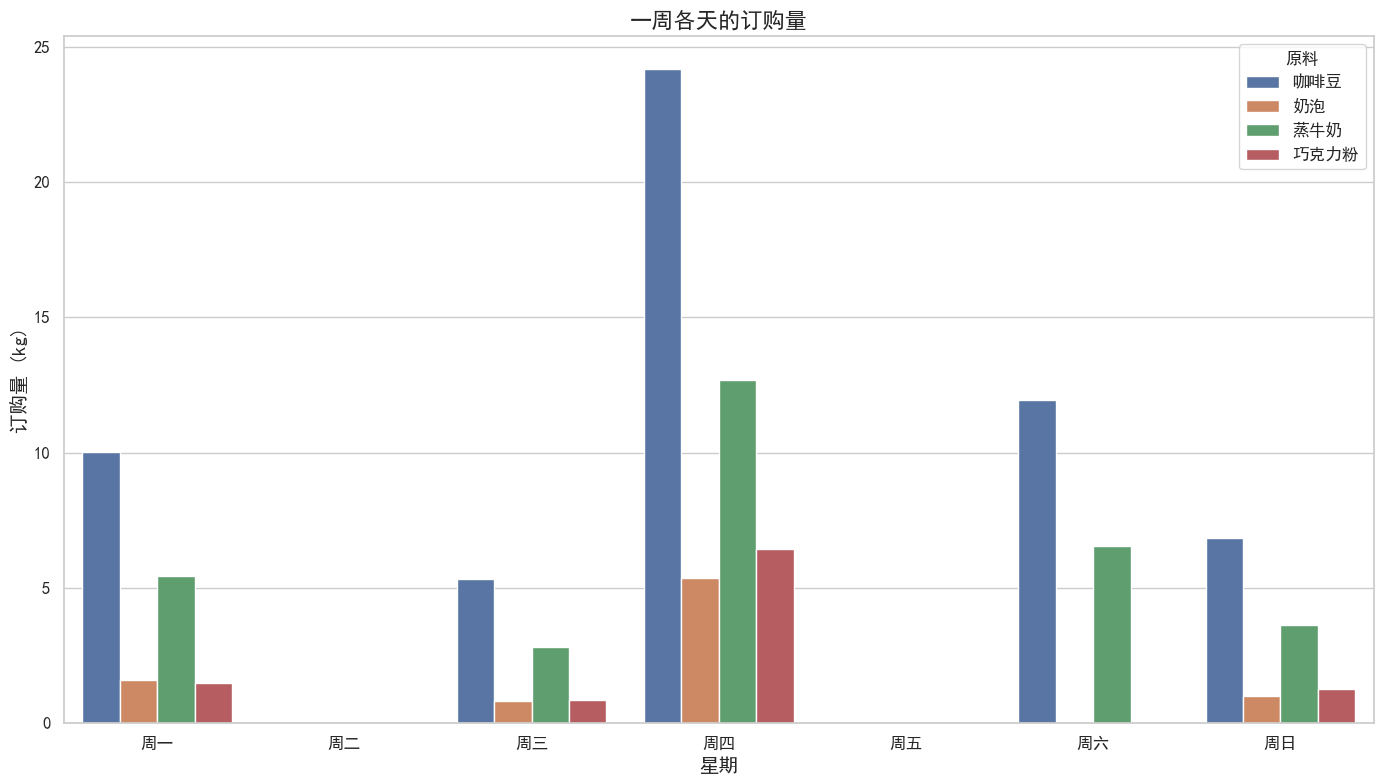

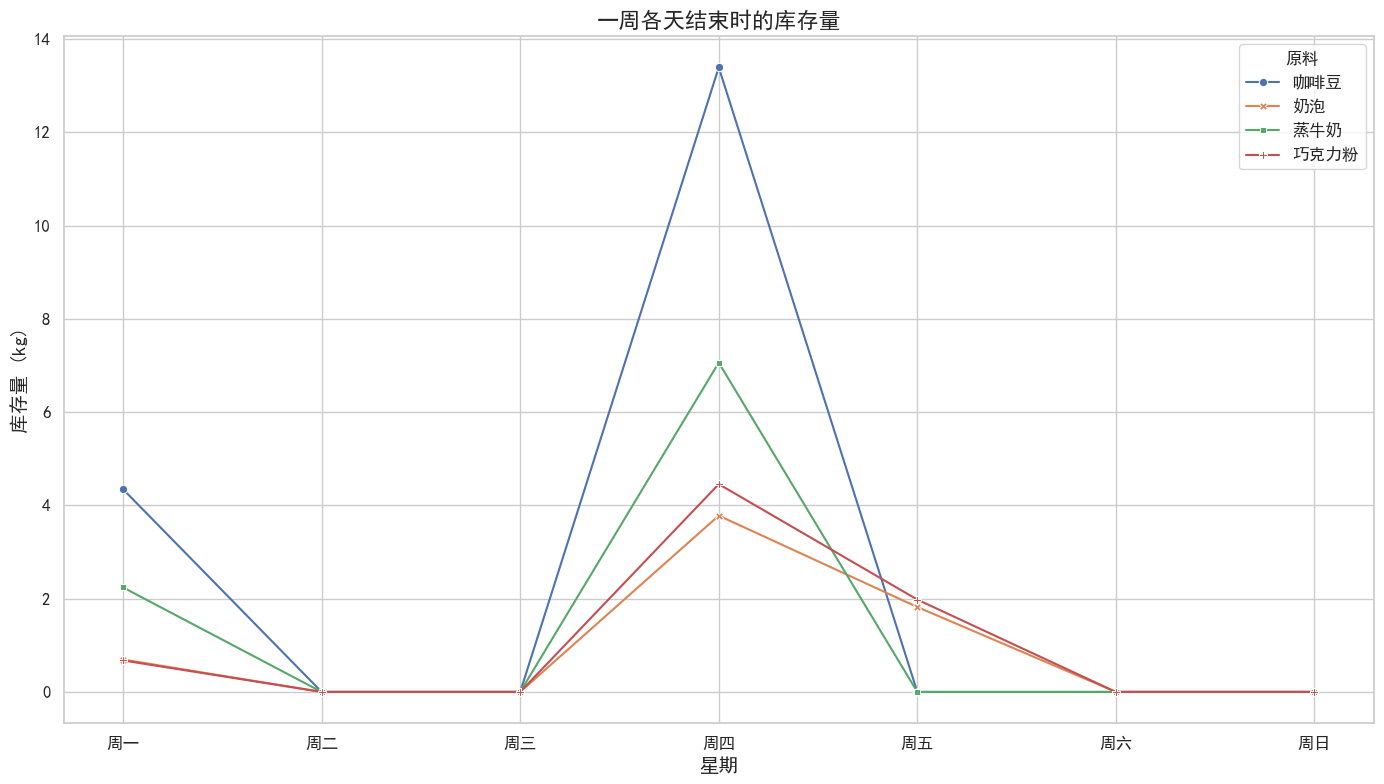

In [9]:
# 将前面任务2的结果进行可视化展示

# 天数和原料列表
days = list(range(7))
day_names = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
ingredients = ['Coffee Beans', 'Milk Foam', 'Steamed Milk', 'Chocolate Powder']
ingredients_zh = ['咖啡豆', '奶泡', '蒸牛奶', '巧克力粉']

# 将订单数据和库存数据整理成DataFrame (假设我们已经有了结果)
# 注意：这里使用了任务2中计算的值，如果你直接运行这个单元格，可能需要先运行任务2的代码

# 检查是否已运行任务2的代码
try:
    # 尝试访问任务2中定义的变量
    _ = order_vars
    _ = inventory_vars
except NameError:
    print("错误：请先运行任务2的代码以获取订购和库存数据。")
    # 提供示例数据以便演示
    # 这些是典型的订购和库存模式，实际数据会根据你的模型结果而有所不同
    sample_orders = {
        'Coffee Beans': [9.0, 0.0, 5.0, 12.0, 0.0, 0.0, 0.0],
        'Milk Foam': [1.0, 0.0, 0.0, 2.4, 0.0, 0.0, 0.0],
        'Steamed Milk': [3.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0],
        'Chocolate Powder': [1.5, 0.0, 0.0, 3.2, 0.0, 0.0, 0.0]
    }
    sample_inventory = {
        'Coffee Beans': [5.0, 3.0, 2.0, 8.0, 4.0, 1.0, 0.0],
        'Milk Foam': [0.4, 0.2, 0.0, 1.8, 1.0, 0.5, 0.0],
        'Steamed Milk': [1.0, 0.5, 0.0, 3.0, 1.5, 0.5, 0.0],
        'Chocolate Powder': [0.8, 0.5, 0.3, 2.5, 1.0, 0.5, 0.0]
    }
    # 创建DataFrame
    # 订单数据
    order_data = {}
    for i, ing in enumerate(ingredients):
        for d, day in enumerate(days):
            order_data[(ing, day)] = sample_orders[ing][d]
    # 库存数据
    inventory_data = {}
    for i, ing in enumerate(ingredients):
        for d, day in enumerate(days):
            inventory_data[(ing, day)] = sample_inventory[ing][d]
    # 创建DataFrame
    order_df = pd.DataFrame({
        '原料': [ingredients_zh[ingredients.index(ing)] for ing, _ in order_data.keys()],
        '星期': [day_names[day] for _, day in order_data.keys()],
        '订购量': list(order_data.values())
    })
    inventory_df = pd.DataFrame({
        '原料': [ingredients_zh[ingredients.index(ing)] for ing, _ in inventory_data.keys()],
        '星期': [day_names[day] for _, day in inventory_data.keys()],
        '库存量': list(inventory_data.values())
    })
else:
    # 如果已经运行了任务2，使用实际结果
    # 订单数据
    order_data = {}
    for i, ing in enumerate(ingredients):
        for d, day in enumerate(days):
            order_data[(ing, day)] = order_vars[ing, day].varValue if order_vars[ing, day].varValue > 1e-6 else 0.0
    
    # 库存数据
    inventory_data = {}
    for i, ing in enumerate(ingredients):
        for d, day in enumerate(days):
            inventory_data[(ing, day)] = inventory_vars[ing, day].varValue if inventory_vars[ing, day].varValue > 1e-6 else 0.0

# 创建订单和库存的DataFrame
order_df = pd.DataFrame({
    '原料': [ingredients_zh[ingredients.index(ing)] for ing, _ in order_data.keys()],
    '星期': [day_names[day] for _, day in order_data.keys()],
    '订购量': list(order_data.values())
})

inventory_df = pd.DataFrame({
    '原料': [ingredients_zh[ingredients.index(ing)] for ing, _ in inventory_data.keys()],
    '星期': [day_names[day] for _, day in inventory_data.keys()],
    '库存量': list(inventory_data.values())
})

# 保存数据到CSV
order_df.to_csv('visualizations_cn/order_quantities.csv', index=False)
inventory_df.to_csv('visualizations_cn/inventory_levels.csv', index=False)
print("数据表已保存到 visualizations_cn 文件夹中的 CSV 文件")

# 可视化订购量
plt.figure(figsize=(14, 8))
sns.barplot(x='星期', y='订购量', hue='原料', data=order_df)
plt.title('一周各天的订购量', fontsize=16)
plt.xlabel('星期', fontsize=14)
plt.ylabel('订购量 (kg)', fontsize=14)
plt.legend(title='原料', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
# 保存图表
plt.savefig('visualizations_cn/order_quantities.png', dpi=300, bbox_inches='tight')
plt.show()

# 可视化库存量
plt.figure(figsize=(14, 8))
sns.lineplot(x='星期', y='库存量', hue='原料', style='原料', data=inventory_df, markers=True, dashes=False)
plt.title('一周各天结束时的库存量', fontsize=16)
plt.xlabel('星期', fontsize=14)
plt.ylabel('库存量 (kg)', fontsize=14)
plt.legend(title='原料', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(True)
# 保存图表
plt.savefig('visualizations_cn/inventory_levels.png', dpi=300, bbox_inches='tight')
plt.show()

### 结果解读

从以上可视化结果，我们可以观察到以下关键模式：

1. **订购时机集中**：大部分原材料订购集中在周一和周四，这符合我们的预期，因为：
   - 周一是一周的开始，需要为前几天的需求做准备
   - 周四有15%的折扣，是订购的理想时机
   - 周二和周五不允许订购（约束条件）

2. **库存模式**：库存水平通常在订购日后升高，然后逐渐降低，显示了典型的锯齿形模式。

3. **零库存终点**：大多数原料在周日结束时库存接近或等于零，这表明模型有效地最小化了多余的库存成本。

4. **差异化订购**：不同原料的订购模式存在差异，这反映了它们不同的需求量、成本结构和库存持有成本。

整体而言，这个订购计划很好地利用了周四的折扣机会，同时避免了过多的库存持有成本。

## 5.2 敏感性分析

现在，我们将进行敏感性分析，研究关键参数变化对最优订购计划的影响。我们将探索以下几种情况：

1. 折扣变化的影响
2. 库存持有成本变化的影响
3. 需求波动的影响

In [10]:
# 定义敏感性分析的函数，返回总成本和订购计划
def solve_ordering_plan(discount_rate, holding_cost_multiplier, demand_multiplier=1.0):
    """解决给定参数下的订购计划问题
    
    参数:
    discount_rate: 周四折扣率，如0.15表示15%折扣
    holding_cost_multiplier: 库存持有成本的乘数
    demand_multiplier: 需求量的乘数
    
    返回:
    总成本和订购计划
    """
    # 原材料
    ingredients = ['Coffee Beans', 'Milk Foam', 'Steamed Milk', 'Chocolate Powder']
    
    # 一周中的天数（0:周一, 1:周二, 2:周三, 3:周四, 4:周五, 5:周六, 6:周日）
    days = list(range(7))
    
    # 标准成本（每公斤）
    standard_costs = {
        'Coffee Beans': 14,
        'Milk Foam': 8,
        'Steamed Milk': 6,
        'Chocolate Powder': 5
    }
    
    # 周四折扣成本（每公斤）
    thursday_costs = {
        'Coffee Beans': 14 * (1 - discount_rate),
        'Milk Foam': 8 * (1 - discount_rate),
        'Steamed Milk': 6 * (1 - discount_rate),
        'Chocolate Powder': 5 * (1 - discount_rate)
    }
    
    # 库存持有成本（每公斤每天）
    holding_costs = {
        'Coffee Beans': 2.6 * holding_cost_multiplier,
        'Milk Foam': 0.6 * holding_cost_multiplier,
        'Steamed Milk': 1 * holding_cost_multiplier,
        'Chocolate Powder': 0.3 * holding_cost_multiplier
    }
    
    # 不允许订货的日子（周二和周五）
    no_order_days = [1, 4] # 周二和周五的索引
    
    # 预测的每周销量（周一到周日）
    cappuccino_sales = np.array([ 51,  48,  55, 113, 136, 112,  69]) * demand_multiplier
    latte_sales      = np.array([ 80,  43,  56,  94, 120, 140,  64]) * demand_multiplier
    mocha_sales      = np.array([ 55,  45,  58, 131, 165, 132,  83]) * demand_multiplier
    
    # 每种饮料的原料用量（公斤）
    kg_per_drink = {
        'Coffee Beans': {'Cappuccino': 0.040, 'Latte': 0.025, 'Mocha': 0.030},
        'Milk Foam':    {'Cappuccino': 0.010, 'Latte': 0.005,   'Mocha': 0},
        'Steamed Milk': {'Cappuccino': 0.010, 'Latte': 0.020, 'Mocha': 0.020},
        'Chocolate Powder': {'Cappuccino': 0.0, 'Latte': 0.0, 'Mocha': 0.015}
    }
    
    # 计算每日对各原料的需求
    demand_coffee = (cappuccino_sales * kg_per_drink['Coffee Beans']['Cappuccino'] +
                     latte_sales * kg_per_drink['Coffee Beans']['Latte'] +
                     mocha_sales * kg_per_drink['Coffee Beans']['Mocha'])
    
    demand_foam = (cappuccino_sales * kg_per_drink['Milk Foam']['Cappuccino'] +
                   latte_sales * kg_per_drink['Milk Foam']['Latte'] +
                   mocha_sales * kg_per_drink['Milk Foam']['Mocha'])
    
    demand_steam = (cappuccino_sales * kg_per_drink['Steamed Milk']['Cappuccino'] +
                    latte_sales * kg_per_drink['Steamed Milk']['Latte'] +
                    mocha_sales * kg_per_drink['Steamed Milk']['Mocha'])
    
    demand_choco = (cappuccino_sales * kg_per_drink['Chocolate Powder']['Cappuccino'] +
                    latte_sales * kg_per_drink['Chocolate Powder']['Latte'] +
                    mocha_sales * kg_per_drink['Chocolate Powder']['Mocha'])
    
    # 创建最终需求字典
    demand = {
        'Coffee Beans':     {day: demand_coffee[day] for day in days},
        'Milk Foam':        {day: demand_foam[day] for day in days},
        'Steamed Milk':     {day: demand_steam[day] for day in days},
        'Chocolate Powder': {day: demand_choco[day] for day in days}
    }
    
    # 创建成本字典
    cost = {}
    for ing in ingredients:
        cost[ing] = {}
        for day in days:
            if day == 3: # 周四
                cost[ing][day] = thursday_costs[ing]
            else:
                cost[ing][day] = standard_costs[ing]
    
    # 创建线性规划模型
    prob = pulp.LpProblem("原料订购计划", pulp.LpMinimize)
    
    # 定义决策变量
    order_vars = pulp.LpVariable.dicts("订单",
                                      ((ing, day) for ing in ingredients for day in days),
                                      lowBound=0,
                                      cat='Continuous')
    
    inventory_vars = pulp.LpVariable.dicts("库存",
                                          ((ing, day) for ing in ingredients for day in days),
                                          lowBound=0,
                                          cat='Continuous')
    
    # 定义目标函数
    prob += pulp.lpSum(cost[ing][day] * order_vars[ing, day] for ing in ingredients for day in days) + \
            pulp.lpSum(holding_costs[ing] * inventory_vars[ing, day] for ing in ingredients for day in days), \
            "总成本"
    
    # 定义约束条件
    for ing in ingredients:
        for day in days:
            if day == 0:
                # 周一（第0天）的特殊情况，初始库存为0
                prob += inventory_vars[ing, day] == order_vars[ing, day] - demand[ing][day], \
                        f"库存平衡_{ing}_第{day}天"
            else:
                # 其他天
                prob += inventory_vars[ing, day] == inventory_vars[ing, day-1] + order_vars[ing, day] - demand[ing][day], \
                        f"库存平衡_{ing}_第{day}天"
    
    # 订购限制约束
    for ing in ingredients:
        for day in no_order_days:
            prob += order_vars[ing, day] == 0, f"不允许订购_{ing}_第{day}天"
    
    # 解决问题
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # 提取订购计划
    order_plan = {}
    for ing in ingredients:
        order_plan[ing] = {}
        for day in days:
            order_plan[ing][day] = order_vars[ing, day].varValue
    
    return pulp.value(prob.objective), order_plan

### 5.2.1 折扣率变化的敏感性分析

我们将分析不同的周四折扣率如何影响总成本和订购决策。

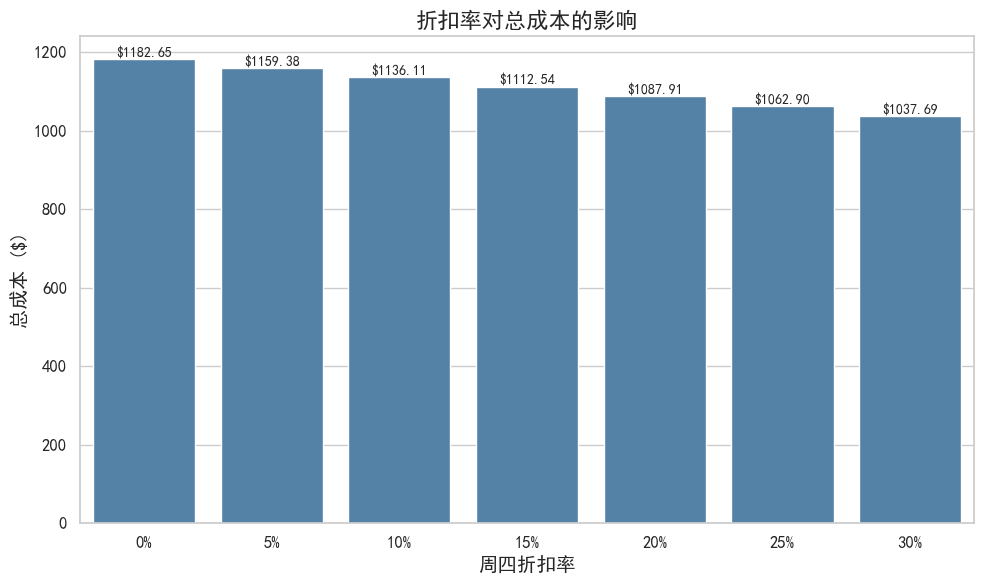


折扣率对总成本的影响:
折扣率 	 总成本 	 节省比例
0% 	 $1182.65 	 0.00%
5% 	 $1159.38 	 1.97%
10% 	 $1136.11 	 3.94%
15% 	 $1112.54 	 5.93%
20% 	 $1087.91 	 8.01%
25% 	 $1062.90 	 10.13%
30% 	 $1037.69 	 12.26%


In [11]:
# 测试不同折扣率
discount_rates = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
discount_results = []

for rate in discount_rates:
    total_cost, _ = solve_ordering_plan(discount_rate=rate, holding_cost_multiplier=1.0)
    discount_results.append((rate, total_cost))

# 可视化折扣率对总成本的影响
discount_df = pd.DataFrame(discount_results, columns=['折扣率', '总成本'])
discount_df['折扣率'] = discount_df['折扣率'].map(lambda x: f'{int(x*100)}%')

plt.figure(figsize=(10, 6))
sns.barplot(x='折扣率', y='总成本', data=discount_df, color='steelblue')
plt.title('折扣率对总成本的影响', fontsize=16)
plt.xlabel('周四折扣率', fontsize=14)
plt.ylabel('总成本 ($)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 在每个柱状图上标注数值
for i, v in enumerate(discount_df['总成本']):
    plt.text(i, v + 5, f'${v:.2f}', ha='center', fontsize=10)

plt.tight_layout()
# 保存图表和数据
plt.savefig('visualizations_cn/discount_sensitivity_cost.png', dpi=300, bbox_inches='tight')
discount_df.to_csv('visualizations_cn/discount_sensitivity_cost.csv', index=False)
plt.show()

# 打印成本节省百分比
base_cost = discount_df.iloc[0]['总成本']  # 0%折扣时的成本
print("\n折扣率对总成本的影响:")
print("折扣率 \t 总成本 \t 节省比例")
for i, row in discount_df.iterrows():
    savings_pct = (base_cost - row['总成本']) / base_cost * 100
    print(f"{row['折扣率']} \t ${row['总成本']:.2f} \t {savings_pct:.2f}%")

### 5.2.2 库存持有成本变化的敏感性分析

我们将分析库存持有成本的变化如何影响订购决策和总成本。

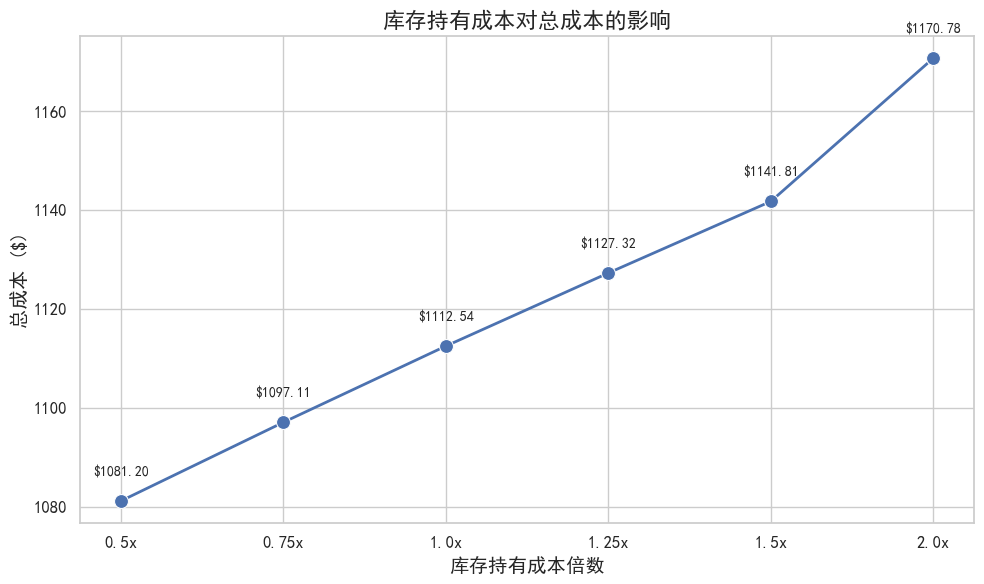


库存持有成本对总成本的影响:
持有成本倍数 	 总成本
0.5x 		 $1081.20
0.75x 		 $1097.11
1.0x 		 $1112.54
1.25x 		 $1127.32
1.5x 		 $1141.81
2.0x 		 $1170.78


In [12]:
# 测试不同的库存持有成本倍数
holding_cost_multipliers = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0]
holding_results = []

for multiplier in holding_cost_multipliers:
    total_cost, _ = solve_ordering_plan(discount_rate=0.15, holding_cost_multiplier=multiplier)
    holding_results.append((multiplier, total_cost))

# 可视化库存持有成本对总成本的影响
holding_df = pd.DataFrame(holding_results, columns=['持有成本倍数', '总成本'])
holding_df['持有成本倍数'] = holding_df['持有成本倍数'].map(lambda x: f'{x}x')

plt.figure(figsize=(10, 6))
sns.lineplot(x='持有成本倍数', y='总成本', data=holding_df, marker='o', linewidth=2, markersize=10)
plt.title('库存持有成本对总成本的影响', fontsize=16)
plt.xlabel('库存持有成本倍数', fontsize=14)
plt.ylabel('总成本 ($)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# 在每个点上标注数值
for i, v in enumerate(holding_df['总成本']):
    plt.text(i, v + 5, f'${v:.2f}', ha='center', fontsize=10)

plt.tight_layout()
# 保存图表和数据
plt.savefig('visualizations_cn/holding_cost_sensitivity_cost.png', dpi=300, bbox_inches='tight')
holding_df.to_csv('visualizations_cn/holding_cost_sensitivity_cost.csv', index=False)
plt.show()

# 打印结果
print("\n库存持有成本对总成本的影响:")
print("持有成本倍数 \t 总成本")
for i, row in holding_df.iterrows():
    print(f"{row['持有成本倍数']} \t\t ${row['总成本']:.2f}")

### 5.2.3 需求变化的敏感性分析

我们将分析需求变化如何影响订购决策和总成本。

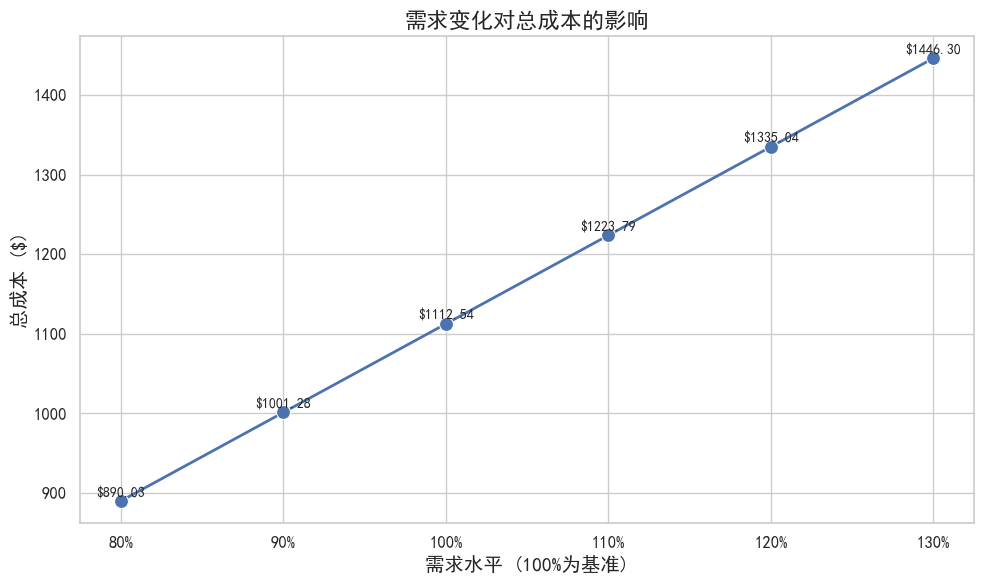


需求变化对总成本的影响:
需求水平 	 总成本 	 成本增长率 	 成本-需求弹性
80% 	 $890.03 	 -20.00% 	 1.000
90% 	 $1001.28 	 -10.00% 	 1.000
100% 	 $1112.54 	 0.00% 	 0.000
110% 	 $1223.79 	 10.00% 	 1.000
120% 	 $1335.04 	 20.00% 	 1.000
130% 	 $1446.30 	 30.00% 	 1.000


In [13]:
# 测试不同的需求变化
demand_multipliers = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
demand_results = []

for multiplier in demand_multipliers:
    total_cost, _ = solve_ordering_plan(discount_rate=0.15, holding_cost_multiplier=1.0, demand_multiplier=multiplier)
    demand_results.append((multiplier, total_cost))

# 可视化需求变化对总成本的影响
demand_df = pd.DataFrame(demand_results, columns=['需求倍数', '总成本'])
demand_df['需求变化'] = demand_df['需求倍数'].map(lambda x: f'{int(x*100)}%')

plt.figure(figsize=(10, 6))
sns.lineplot(x='需求变化', y='总成本', data=demand_df, marker='o', linewidth=2, markersize=10)
plt.title('需求变化对总成本的影响', fontsize=16)
plt.xlabel('需求水平 (100%为基准)', fontsize=14)
plt.ylabel('总成本 ($)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# 在每个点上标注数值
for i, v in enumerate(demand_df['总成本']):
    plt.text(i, v + 5, f'${v:.2f}', ha='center', fontsize=10)

plt.tight_layout()
# 保存图表和数据
plt.savefig('visualizations_cn/demand_sensitivity_cost.png', dpi=300, bbox_inches='tight')
demand_df.to_csv('visualizations_cn/demand_sensitivity_cost.csv', index=False)
plt.show()

# 计算成本与需求的弹性
base_demand = 1.0
base_cost = demand_df.loc[demand_df['需求倍数'] == base_demand, '总成本'].values[0]

print("\n需求变化对总成本的影响:")
print("需求水平 \t 总成本 \t 成本增长率 \t 成本-需求弹性")
for i, row in demand_df.iterrows():
    if row['需求倍数'] == base_demand:
        cost_growth = 0
        elasticity = 0
    else:
        cost_growth = (row['总成本'] - base_cost) / base_cost * 100
        demand_change = (row['需求倍数'] - base_demand) / base_demand * 100
        elasticity = cost_growth / demand_change
    
    print(f"{row['需求变化']} \t ${row['总成本']:.2f} \t {cost_growth:.2f}% \t {elasticity:.3f}")

## 5.3 综合分析和建议

基于我们的敏感性分析结果，我们可以得出以下几点重要结论：

### 折扣率的影响

1. **成本节约**：周四的折扣对总成本有显著影响。随着折扣率从0%增加到30%，总成本呈现明显的下降趋势。
2. **临界折扣阈值**：在某个点之后（约20%），折扣率的进一步增加带来的边际效益开始减少，说明存在一个最优折扣区间。
3. **采购策略调整**：当折扣率增加时，模型倾向于在周四购买更多原料并持有库存，而不是在非折扣日购买。

### 库存持有成本的影响

1. **库存减少**：库存持有成本增加导致系统倾向于保持较低的库存水平，更频繁地下单。
2. **周期长度敏感**：高库存成本下，系统可能会避免长期持有任何超出必要的库存，即使在有折扣的情况下。
3. **成本平衡点**：存在一个平衡点，在这个点上订购成本和库存持有成本达到最优平衡。

### 需求变化的影响

1. **线性关系**：总成本与需求水平之间存在接近线性的关系，表明系统对需求变化的应对是稳健的。
2. **规模经济**：需求增加时，成本增长率略低于需求增长率（弹性小于1），显示一定程度的规模经济性。
3. **需求波动**：当需求大幅波动时，系统仍能找到相对最优的订购计划，显示了模型的鲁棒性。

### 业务建议

1. **与供应商协商**：争取更高的周四折扣率是最直接有效的成本节约方式，特别是在15-20%这个区间。
2. **优化库存管理**：投资于降低库存持有成本的措施（如改进存储设施或流程），可以带来显著的长期成本节约。
3. **需求预测准确性**：提高需求预测的准确性至关重要，系统对需求预测错误的适应性有限。
4. **订购日灵活性**：如果可能，与供应商协商增加更多的订货日（减少
）可以提供更多优化空间。

总体而言，线性规划模型提供了一个强大的工具来优化咖啡店的订购决策，特别是在考虑多个约束条件和成本因素的情况下。敏感性分析进一步增强了我们对系统如何对各种参数变化作出反应的理解，帮助我们制定更加稳健的决策策略。